# Environment

## Imports

In [42]:
import scanpy as sc
import numpy as np
from muon import atac as ac
import torch
import seaborn as sns

from src.peak2vec.models import Peak2Vec

## Load data

### Original AnnData

In [2]:
adata = sc.read_h5ad("data/pbmc10k_atac_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'binary'

### Peak Embeddings

In [41]:
checkpoint_path = 'data/pbmc10k_demo/checkpoints/final_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cpu"))
n_peaks = checkpoint["model_state_dict"]["in_embedding.weight"].shape[0]
embedding_dim = checkpoint["model_state_dict"]["in_embedding.weight"].shape[
    1
]
model = Peak2Vec(
    n_peaks=n_peaks,
    embedding_dim=embedding_dim,
    pos_weight=1.0,
    sparse=False,
    tie_weights=False,
)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [4]:
embeddings_out = model.get_peak_embeddings(normalize=True, which="out").numpy()

In [5]:
del model

# Visualise

## Tf-id on original data

In [6]:
ac.pp.tfidf(adata, scale_factor=1e4)

In [7]:
ac.tl.lsi(adata)

In [18]:
adata.obsm["X_pca"] = sc.pp.pca(adata.obsm["X_lsi"], n_comps=30)

In [8]:
sc.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=15, n_pcs=30)

In [9]:
sc.tl.umap(adata, random_state=4)

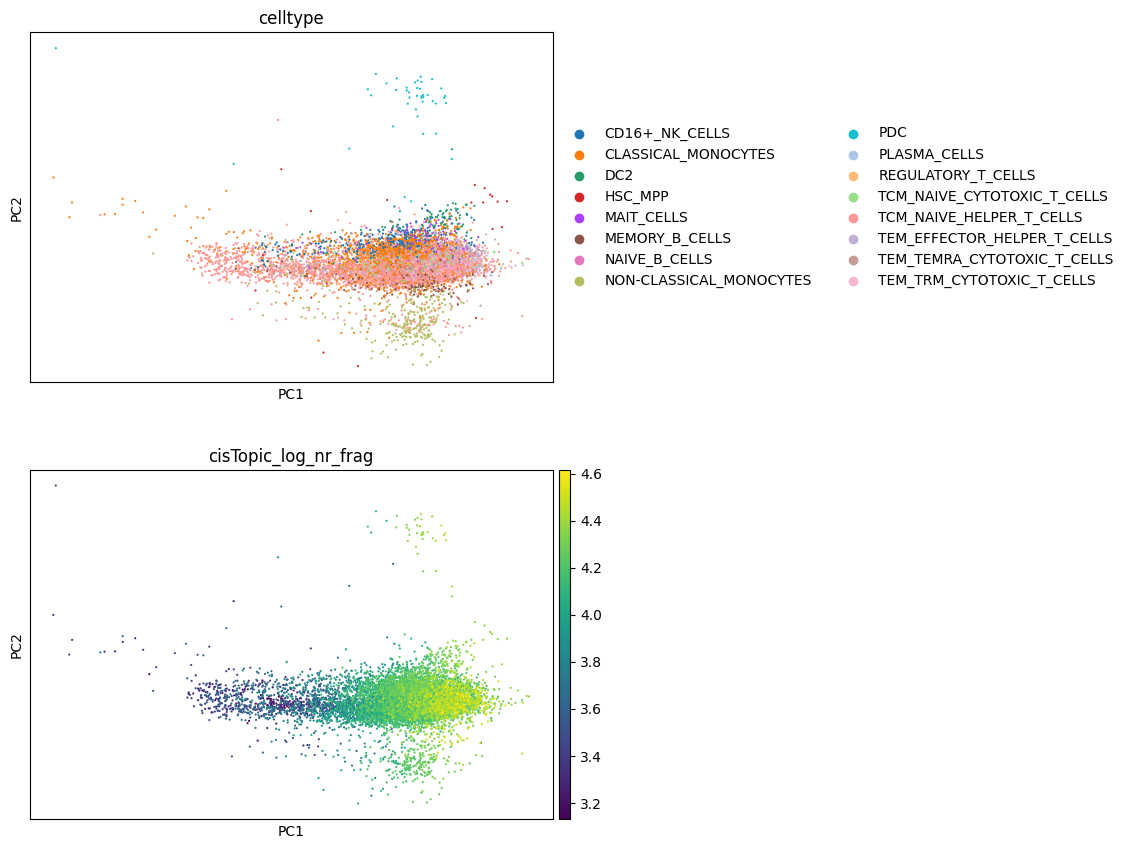

In [19]:
sc.pl.pca(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)

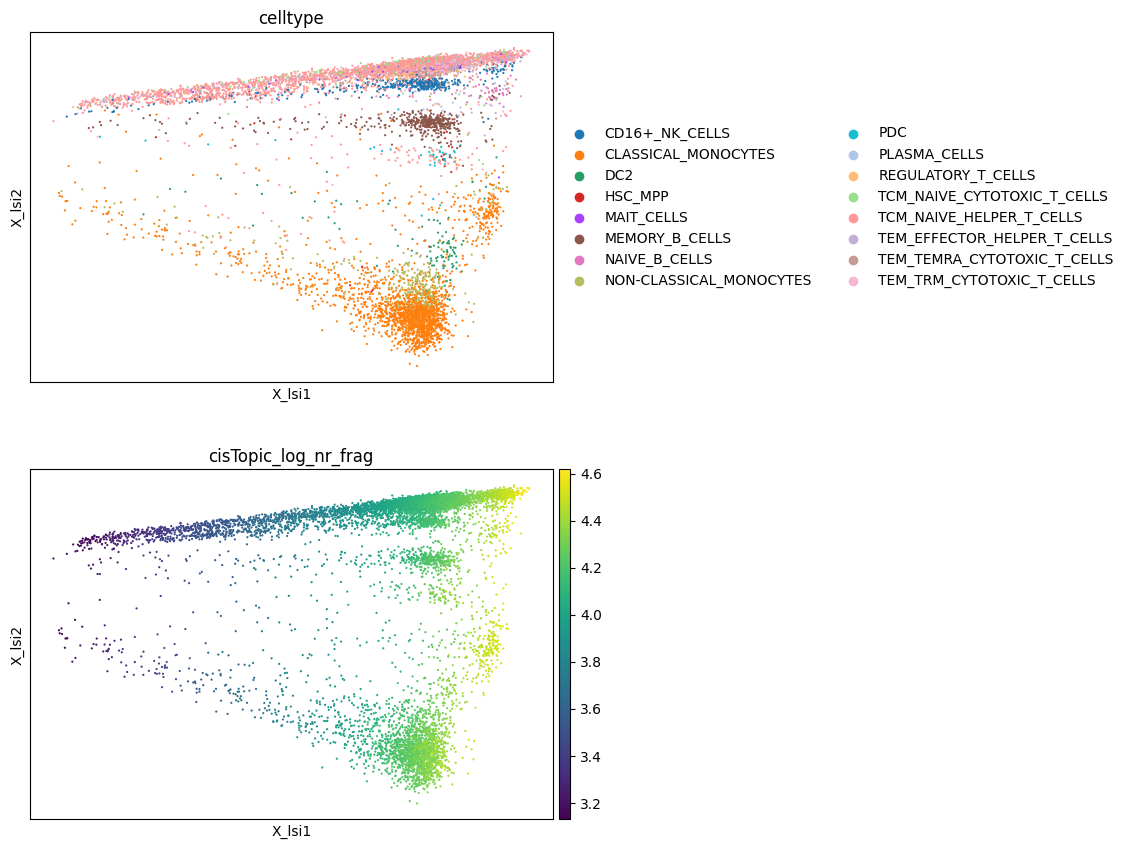

In [11]:
sc.pl.embedding(adata, basis="X_lsi", color=[ "celltype", "cisTopic_log_nr_frag"],  size=10, ncols=1)

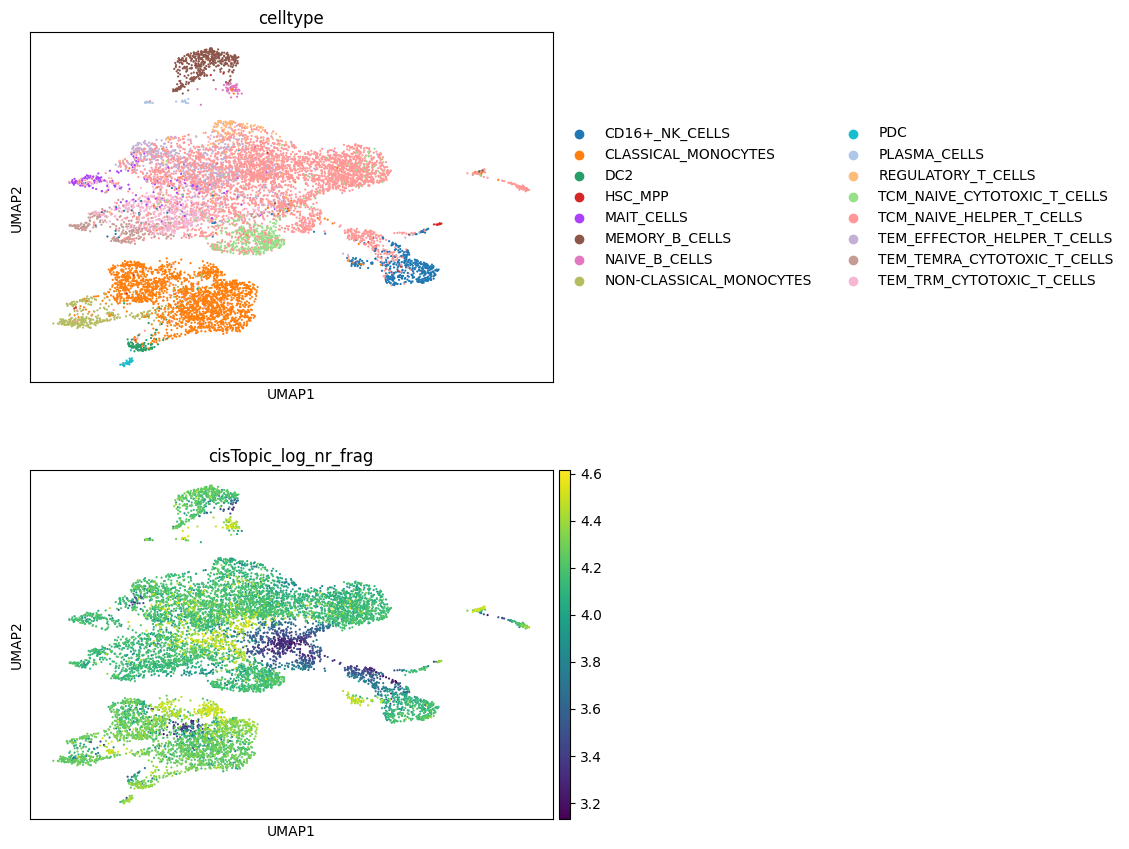

In [10]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)

## Weighted peak embeddings

In [20]:
adata

AnnData object with n_obs × n_vars = 10006 × 260822
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'lsi', 'neighbors', 'umap', 'celltyp

In [21]:
embeddings_out.shape

(260822, 128)

In [28]:
weighted_emb = adata.X @ embeddings_out
norms = np.linalg.norm(weighted_emb, axis=1, keepdims=True) + 1e-10
weighted_emb = weighted_emb / norms
weighted_emb.shape

(10006, 128)

In [ ]:
adata.obsm["X_peak2vec_weighted"] = weighted_emb

In [31]:
adata.obsm["X_pca"] = sc.pp.pca(adata.obsm["X_peak2vec_weighted"], n_comps=50)

In [32]:
sc.pp.neighbors(adata, use_rep="X_peak2vec_weighted", n_neighbors=15, n_pcs=50)

In [33]:
sc.tl.umap(adata, random_state=4)

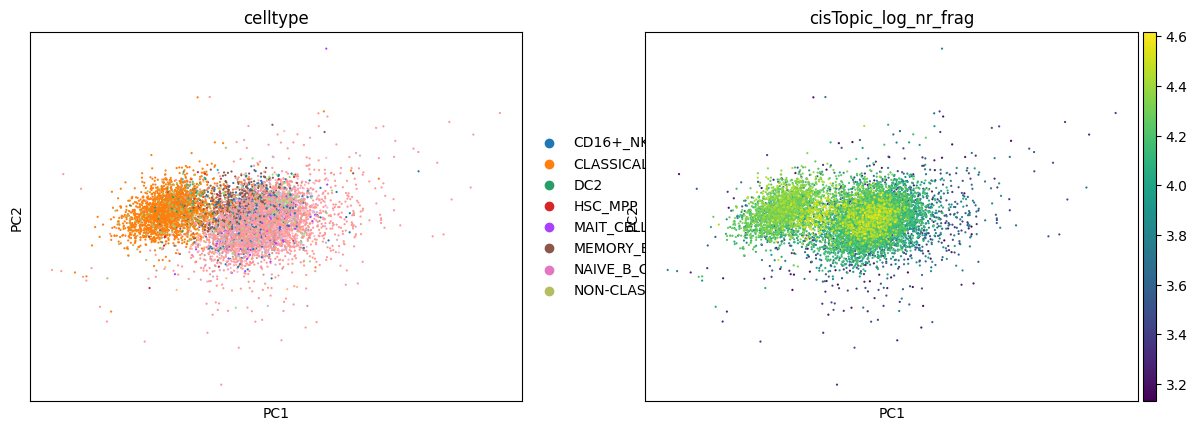

In [40]:
sc.pl.pca(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=2, size=10)

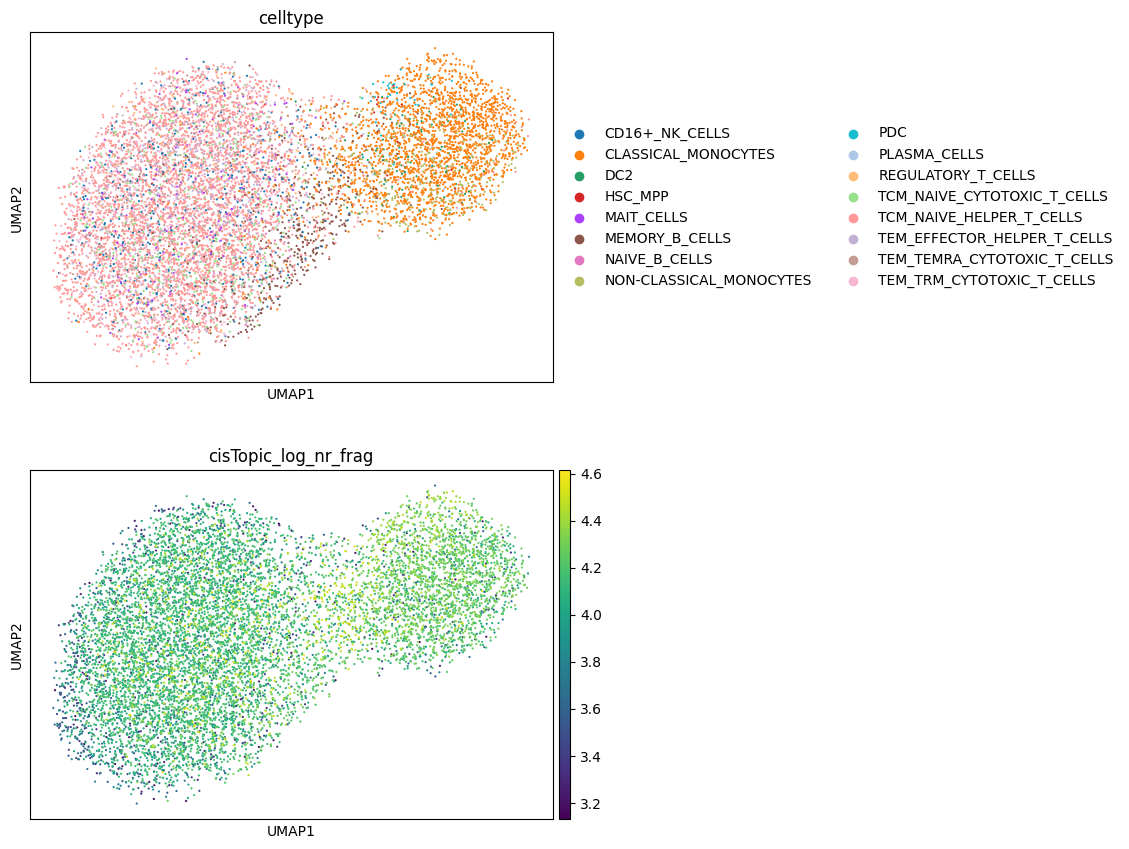

In [36]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)

## Weighted peak embeddings (filtered)

In [50]:
embeddings_out_norm = model.get_peak_embeddings(normalize=True, which="out").numpy()
embeddings_out = model.get_peak_embeddings(normalize=False, which="out").numpy()

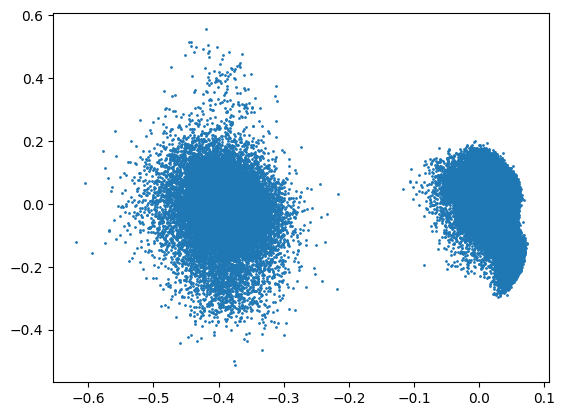

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings_out_norm)

plt.plot(pca_result[:,0], pca_result[:,1], '.', markersize=2)

In [55]:
pc1 = pca_result[:, 0]
(pc1 >= -0.2).sum()

np.int64(244316)

<Axes: xlabel='norm', ylabel='Count'>

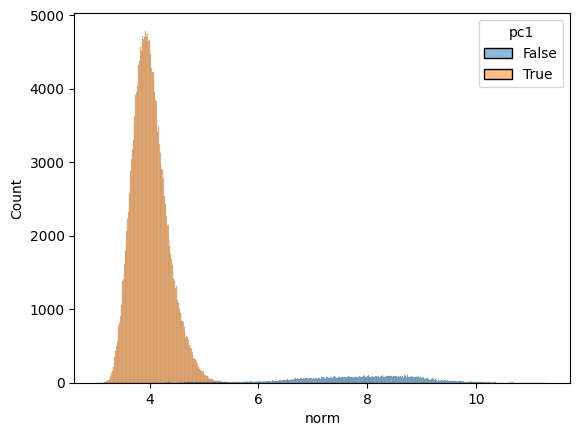

In [58]:
df = pd.DataFrame()
df['pc1'] = pc1 >= -0.2
df['norm'] = np.linalg.norm(embeddings_out, axis=1)

sns.histplot(data=df, x='norm', hue='pc1')

In [60]:
adata_subsample = adata[:, pc1 >= -0.2]
adata_subsample

View of AnnData object with n_obs × n_vars = 10006 × 244316
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'lsi', 'neighbors', 'umap', 

In [63]:
weighted_emb = adata_subsample.X @ embeddings_out_norm[pc1 >= -0.2, :]
norms = np.linalg.norm(weighted_emb, axis=1, keepdims=True) + 1e-10
weighted_emb = weighted_emb / norms
weighted_emb.shape

(10006, 128)

In [64]:
adata_subsample.obsm["X_peak2vec_weighted"] = weighted_emb

C:\Users\claptar\AppData\Local\Temp\ipykernel_50452\1992629888.py:1: ImplicitModificationWarning: Setting element `.obsm['X_peak2vec_weighted']` of view, initializing view as actual.
  adata_subsample.obsm["X_peak2vec_weighted"] = weighted_emb


In [65]:
adata_subsample.obsm["X_pca"] = sc.pp.pca(adata_subsample.obsm["X_peak2vec_weighted"], n_comps=50)

In [66]:
sc.pp.neighbors(adata_subsample, use_rep="X_peak2vec_weighted", n_neighbors=15, n_pcs=50)

In [67]:
sc.tl.umap(adata_subsample, random_state=4)

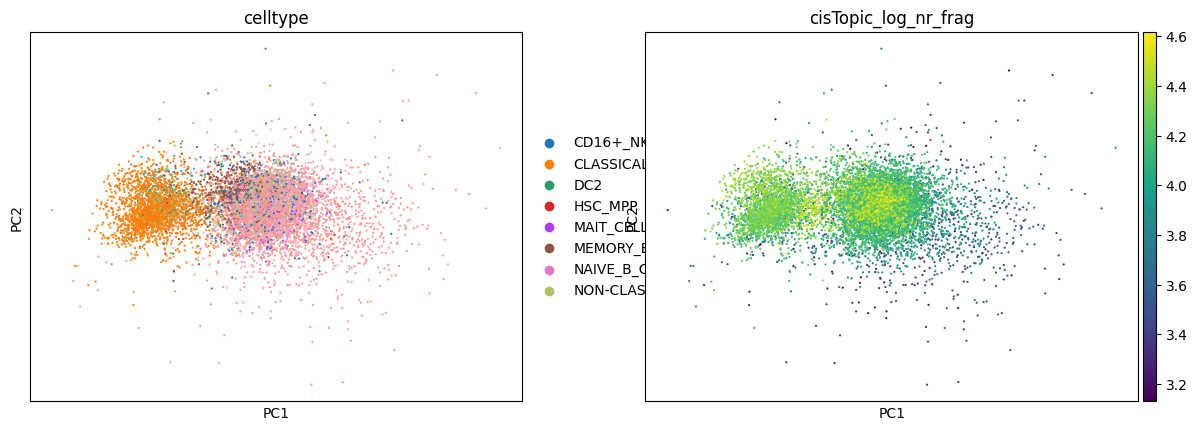

In [68]:
sc.pl.pca(adata_subsample, color=["celltype", "cisTopic_log_nr_frag"], ncols=2, size=10)

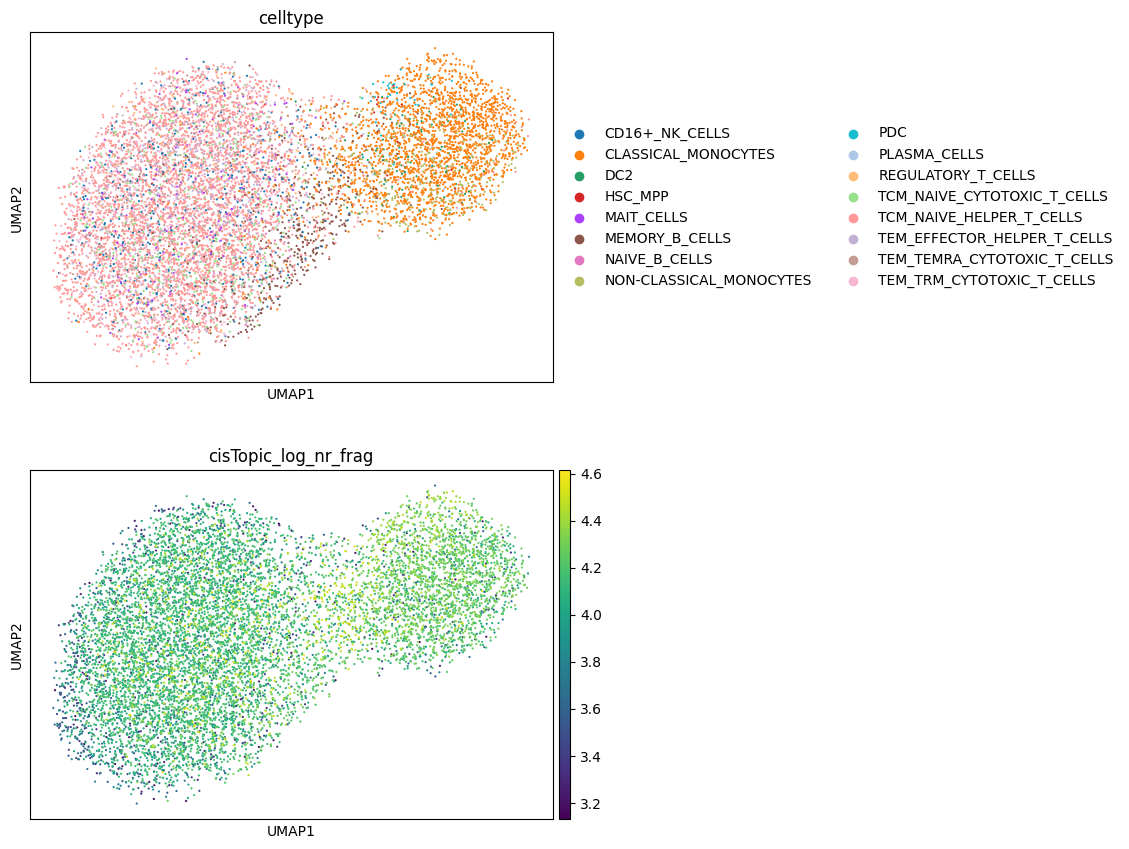

In [69]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)

## Weighted peak embeddings (filtered in)

In [70]:
embeddings_out_norm = model.get_peak_embeddings(normalize=True, which="in").numpy()
embeddings_out = model.get_peak_embeddings(normalize=False, which="in").numpy()

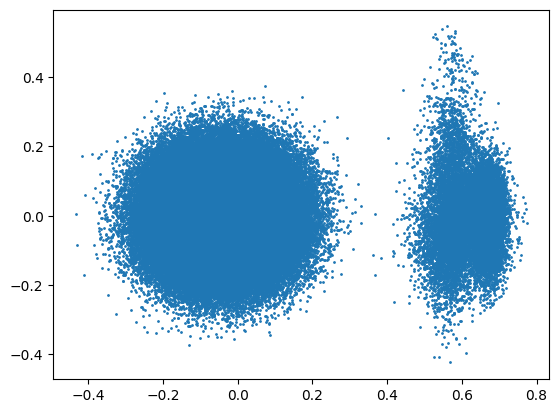

In [71]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings_out_norm)

plt.plot(pca_result[:,0], pca_result[:,1], '.', markersize=2)

In [76]:
pc1 = pca_result[:, 0]
cond = pc1 >= 0.4
(cond).sum()

np.int64(16588)

<Axes: xlabel='norm', ylabel='Count'>

c:\projects\peak2vec\.venv\Lib\site-packages\IPython\core\events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\projects\peak2vec\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


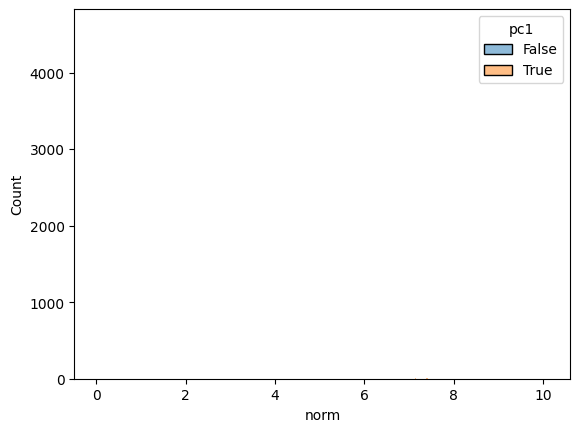

In [77]:
df = pd.DataFrame()
df['pc1'] = cond
df['norm'] = np.linalg.norm(embeddings_out, axis=1)

sns.histplot(data=df, x='norm', hue='pc1')

In [78]:
adata_subsample = adata[:, cond]
adata_subsample

View of AnnData object with n_obs × n_vars = 10006 × 16588
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'celltype', 'n_features_per_cell', 'total_fragment_counts'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'lsi', 'neighbors', 'umap', '

In [79]:
weighted_emb = adata_subsample.X @ embeddings_out_norm[cond, :]
norms = np.linalg.norm(weighted_emb, axis=1, keepdims=True) + 1e-10
weighted_emb = weighted_emb / norms
weighted_emb.shape

(10006, 128)

In [80]:
adata_subsample.obsm["X_peak2vec_weighted"] = weighted_emb

C:\Users\claptar\AppData\Local\Temp\ipykernel_50452\1992629888.py:1: ImplicitModificationWarning: Setting element `.obsm['X_peak2vec_weighted']` of view, initializing view as actual.
  adata_subsample.obsm["X_peak2vec_weighted"] = weighted_emb


In [81]:
adata_subsample.obsm["X_pca"] = sc.pp.pca(adata_subsample.obsm["X_peak2vec_weighted"], n_comps=50)

In [82]:
sc.pp.neighbors(adata_subsample, use_rep="X_peak2vec_weighted", n_neighbors=15, n_pcs=50)

In [83]:
sc.tl.umap(adata_subsample, random_state=4)

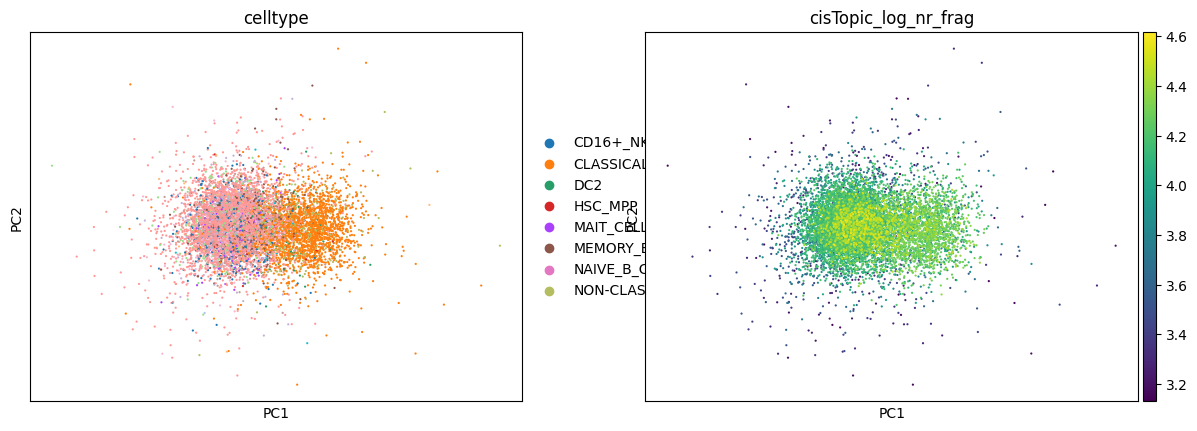

In [84]:
sc.pl.pca(adata_subsample, color=["celltype", "cisTopic_log_nr_frag"], ncols=2, size=10)

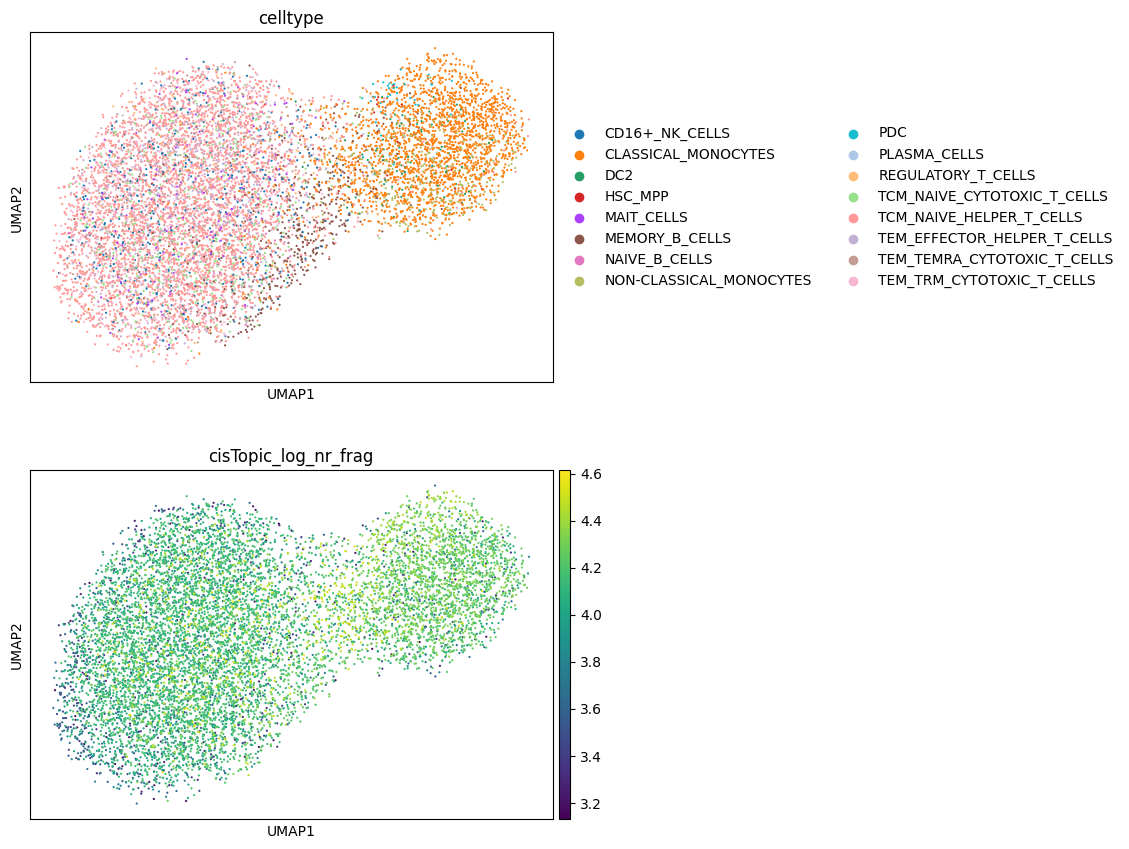

In [85]:
sc.pl.umap(adata, color=["celltype", "cisTopic_log_nr_frag"], ncols=1, size=10)